### Natural Language Processing - Final Project
#### Music Genre, Era & Popularity Prediction

##### Submitted By:
* Gilad Gecht 
* Aviya Amsalem

##### Submitted To:
* Nava Shaked, PhD

<img src="http://melodrive.com/blog/wp-content/uploads/2017/03/styles.png">

### Metadata:
##### Table 1: Artists
* Artist - STRING - The name of the specific artist
* Songs - INT - The amount of songs the artist released
* Popularity - FLOAT - the artist's popularity 
* Link - STRING - The domain to the artists' page
* Genre - STRING - The MAIN artist's genre
* Genres - STRING - Sub genres the artist also implements in his music style

###### Table 2: Lyrics
* ALink - STRING - The domain to the artist's page
* SName - STRING - The artist's/band's song name
* SLink - STRING - HTML link to the artist's page
* Lyric - STRING - The lyrics of the specific song 
* Idion - STRING - The language of the specific song

###### Table 3: Lyrics2
* song - STRING - Song's name
* year - INT - The year the song was released
* artist - STRING - The name of the artist/band
* genre - STRING - The artist's main genre
* lyrics - STRING - The lyrics of the specific song

In [1]:
# Standart Imports

import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import warnings
import time
import nltk
import os
import re


from scipy import sparse
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer

englishStemmer = SnowballStemmer("english")
warnings.simplefilter("ignore")


%matplotlib inline

In [2]:
# Utility Functions

def read_datasets(dataset_name,index_col=None):
    path = 'music_datasets/'
    df = pd.read_csv(os.path.join(path, dataset_name), index_col=index_col)
    
    return df

def generate_CDF(data, feature):

    temp = data[feature].value_counts().sort_index()
    temp /= np.sum(temp.values)
    indice_list = temp.index
    temp = temp.reset_index().drop('index',axis=1)
    CDF = np.zeros(len(temp))
    CDF[0] = temp.iloc[0,0]


    for i in range(1, len(temp)):
        CDF[i] = CDF[i-1] + temp.iloc[i,0]
    return CDF, indice_list

def describe_dataset(data, name="Dataset"):
    assert isinstance(data, pd.DataFrame), "Not a dataframe"
    assert data.shape[0] > 0, "Data has no samples"
    
    print("{} has : #{} Rows & #{} Columns\n ".format(name,data.shape[0], data.shape[1]))
    print("Feature information:")
    print(data.info())

    print(data.describe())
    data.head(5)
    
def check_missing_vaues(data):
    return data.isna().sum() * 100 / data.shape[0]
    
    
def pos_counter(data, pos_list):
    for row in range(len(data)):
        try:
            pos_list.append(data['part_of_speech'][row][:, 1])
        except:
            pass
    pos_series = pd.Series(np.array(pos_list))
    pos_series = pos_series.apply(lambda x: ' '.join(x))
    return pd.DataFrame.from_dict(dict(Counter(pos_series.str.cat().split())), orient='index')
    

def count_genre_pos(data, genres):
    
    pos_rock     = []
    pos_hip_hop  = []
    pos_pop_rock = []
    pos_rap      = []
    pos_indie    = []
    pos_pop      = []
    
    for gen in genres:
        gen_df =  data[data['Genre'] == gen].copy().reset_index(drop=True)
        if(gen == "Rock"):
            rock_counter = pos_counter(data=gen_df, pos_list=pos_rock)

        elif(gen == "Rap"):
            rap_counter = pos_counter(data=gen_df, pos_list=pos_rap)
            
        elif(gen == "Indie"):
            indie_counter = pos_counter(data=gen_df, pos_list=pos_indie)
            
        elif(gen == "Pop"):
            pop_counter = pos_counter(data=gen_df, pos_list=pos_pop)
            
        elif(gen == "Hip Hop"):
            hip_hop_counter = pos_counter(data=gen_df, pos_list=pos_hip_hop)
            
        elif(gen == "Pop/Rock"):
            pop_rock_counter = pos_counter(data=gen_df, pos_list=pos_pop_rock)
            
    return rock_counter, rap_counter, indie_counter, pop_counter, hip_hop_counter, pop_rock_counter

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]))

## Data Exploration

In [3]:
# Read the datasets

lyrics = read_datasets('lyrics.csv')
artists = read_datasets('artists.csv')
lyrics2 = read_datasets(dataset_name='lyrics2.csv', index_col=0)

In [4]:
# Getting first impression from each table is crucial to understand what we're dealing with
describe_dataset(lyrics2)
lyrics2.head()

Dataset has : #362237 Rows & #5 Columns
 
Feature information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 362237 entries, 0 to 362236
Data columns (total 5 columns):
song      362235 non-null object
year      362237 non-null int64
artist    362237 non-null object
genre     362237 non-null object
lyrics    266557 non-null object
dtypes: int64(1), object(4)
memory usage: 16.6+ MB
None
                year
count  362237.000000
mean     2008.537596
std         9.908024
min        67.000000
25%      2006.000000
50%      2008.000000
75%      2014.000000
max      2038.000000


,song,year,artist,genre,lyrics
index,,,,,
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


Can you spot the anomality?

In [5]:
'''
We can see that there's some abnormality in our data, for instance
the maximum value of our year column is the year 2038, and... we'e not there yet...
Also, the minimum value is 67, now unless that's some sort of biblycal song, it might noise as well

lets check them out
'''
lyrics2[(lyrics2['year'] == 67) | (lyrics2['year'] == 2038)]

,song,year,artist,genre,lyrics
index,,,,,
112159,atchim,2038,anita,Rock,NaN
112160,o-areias,2038,anita,Rock,NaN
112161,era-uma-vez-um-cavalo,2038,anita,Rock,NaN
112162,anita,2038,anita,Rock,NaN
112163,todos-os-patinhos,2038,anita,Rock,NaN
112164,joana-come-a-papa,2038,anita,Rock,NaN
112165,atirei-o-pau-ao-gato,2038,anita,Rock,NaN
112166,eu-vi-um-sapo,2038,anita,Rock,NaN
112167,pipi-das-meias-altas,2038,anita,Rock,NaN


Lets clean these anomalies and see our data again

In [6]:
'''
So, as we persumed - it is noise, I doubt Hip-Hop was a thing back in the year 67 (Not 1967).
So, we'll simply drop these rows
'''

lyrics2 = lyrics2.drop(lyrics2[(lyrics2['year'] == 67) | (lyrics2['year'] == 2038)].index).reset_index(drop=True)
lyrics2.describe()

,year
count,362226.000000
mean,2008.542142
std,9.367029
min,112.000000
25%,2006.000000
50%,2008.000000
75%,2014.000000
max,2016.000000


In [7]:
'''
seems fine, now lets check the other dataframes
'''
describe_dataset(lyrics)
lyrics.head(5)

Dataset has : #209522 Rows & #5 Columns
 
Feature information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209522 entries, 0 to 209521
Data columns (total 5 columns):
ALink    209522 non-null object
SName    209522 non-null object
SLink    209522 non-null object
Lyric    209484 non-null object
Idiom    206375 non-null object
dtypes: object(5)
memory usage: 8.0+ MB
None
                ALink   SName                SLink         Lyric    Idiom
count          209522  209522               209522        209484   206375
unique           2993  128083               167499        164789       47
top     /chris-brown/   Intro  /m-i-a/y-a-l-a.html  Instrumental  ENGLISH
freq             1176      80                    6           592   114723


,ALink,SName,SLink,Lyric,Idiom
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time. There was no way of ...,ENGLISH
1,/10000-maniacs/,Because The Night,/10000-maniacs/because-the-night.html,"Take me now, baby, here as I am. Hold me close...",ENGLISH
2,/10000-maniacs/,These Are Days,/10000-maniacs/these-are-days.html,These are. These are days you'll remember. Nev...,ENGLISH
3,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,"A lie to say, ""O my mountain has coal veins an...",ENGLISH
4,/10000-maniacs/,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,Trudging slowly over wet sand. Back to the ben...,ENGLISH


In [8]:
describe_dataset(artists)
artists.head(5)

Dataset has : #3242 Rows & #6 Columns
 
Feature information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3242 entries, 0 to 3241
Data columns (total 6 columns):
Artist        3242 non-null object
Songs         3242 non-null int64
Popularity    3242 non-null float64
Link          3242 non-null object
Genre         3242 non-null object
Genres        3238 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 152.0+ KB
None
             Songs   Popularity
count  3242.000000  3242.000000
mean     53.907465     1.522455
std      78.212829     6.965121
min       0.000000     0.000000
25%       4.000000     0.000000
50%      17.000000     0.000000
75%      77.000000     0.500000
max     759.000000   246.800000


,Artist,Songs,Popularity,Link,Genre,Genres
0,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
1,12 Stones,75,0.3,/12-stones/,Rock,Rock; Gospel/Religioso; Hard Rock; Grunge; Roc...
2,311,196,0.5,/311/,Rock,Rock; Surf Music; Reggae; Ska; Pop/Rock; Rock ...
3,4 Non Blondes,15,7.5,/4-non-blondes/,Rock,Rock; Pop/Rock; Rock Alternativo; Grunge; Blue...
4,A Cruz Está Vazia,13,0.0,/a-cruz-esta-vazia/,Rock,Rock


How about now? Can you spot the anomality?

In [9]:
'''
We can see that there's an artist with a popularity value of 246.
Now that might not seem strange but considering the fact, the average value is 1.5,
with a standart deviation of 7 and a 75 percentile with a value of 0.5, its probably a mistake

Lets see the sample
'''

artists[artists['Popularity'] == 246.8]

,Artist,Songs,Popularity,Link,Genre,Genres
723,Ariana Grande,155,246.8,/ariana-grande/,Pop,Pop; Dance; Romântico; Pop/Rock; World Music; ...


It seems like the noisy sample is Ariana Grande,  
and by chance I happen to know is very popular currently,  
this actually might not be a noisy sample.  
So for now, we'll keep it

Since we are going to work on a single dataframe in the future, we will have to merge our existing dataframes into a single dataframe containing all of our needed features.  
In order to this in a clean and smooth manner, we will first have to tinker with our features to make them concice with one another.


This means:
* Column names changed to a unified name
* Missing data removal which will cause sparse rows

In [10]:
'''
First we'll create dictionaries containing every artist's Genre, Popularity and Sub-Genres

    genre: Main artists's genre
    popularity: The artists's popularity
    genres: The artist's sub-genres
'''

genre = dict(zip(artists['Link'], artists['Genre']))
popularity = dict(zip(artists['Link'], artists['Popularity']))
genres = dict(zip(artists['Link'], artists['Genres']))

In [11]:
# We'll filter out artists who appear in our main dataset, but do not appear in our Artit's table
# This is because some artist's do not have a popularity score in our artist's dataset

artist_names = list(set(artists.Link.values))
filtered_lyrics = lyrics[lyrics['ALink'].isin(artist_names)].copy()

In [12]:
filtered_lyrics['Genre'] = filtered_lyrics['ALink'].apply(lambda x: genre[x])
filtered_lyrics['Popularity'] = filtered_lyrics['ALink'].apply(lambda x: popularity[x])
filtered_lyrics['Genres'] = filtered_lyrics['ALink'].apply(lambda x: genres[x])

After Cleaning our data and merging our datasets we get the following dataset

In [13]:
filtered_lyrics.head(10)

,ALink,SName,SLink,Lyric,Idiom,Genre,Popularity,Genres
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time. There was no way of ...,ENGLISH,Pop,0.3,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
1,/10000-maniacs/,Because The Night,/10000-maniacs/because-the-night.html,"Take me now, baby, here as I am. Hold me close...",ENGLISH,Pop,0.3,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
2,/10000-maniacs/,These Are Days,/10000-maniacs/these-are-days.html,These are. These are days you'll remember. Nev...,ENGLISH,Pop,0.3,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
3,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,"A lie to say, ""O my mountain has coal veins an...",ENGLISH,Pop,0.3,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
4,/10000-maniacs/,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,Trudging slowly over wet sand. Back to the ben...,ENGLISH,Pop,0.3,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
5,/10000-maniacs/,Don't Talk,/10000-maniacs/dont-talk.html,"Don't talk, I will listen. Don't talk, you kee...",ENGLISH,Pop,0.3,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
6,/10000-maniacs/,Across The Fields,/10000-maniacs/across-the-fields.html,"Well they left then in the morning, a hundred ...",ENGLISH,Pop,0.3,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
7,/10000-maniacs/,Planned Obsolescence,/10000-maniacs/planned-obsolescence.html,[ music: Dennis Drew/lyric: Natalie Merchant ]...,ENGLISH,Pop,0.3,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
8,/10000-maniacs/,Rainy Day,/10000-maniacs/rainy-day.html,On bended kneeI've looked through every window...,ENGLISH,Pop,0.3,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
9,/10000-maniacs/,Anthem For Doomed Youth,/10000-maniacs/anthem-for-doomed-youth.html,For whom do the bells toll. When sentenced to ...,ENGLISH,Pop,0.3,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...


In this project we'll work solely on "English" text, in the future - other languages might be added to the model.
Although we're cutting almost hald of the dataset, leaving only 100k samples, this should suffice for an efficient learning process and check our hypothesis.

In [14]:
filtered_lyrics = filtered_lyrics[filtered_lyrics['Idiom'] == 'ENGLISH']

In [15]:
artists[artists['Link'] == '/10000-maniacs/']

,Artist,Songs,Popularity,Link,Genre,Genres
0,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
1947,10000 Maniacs,110,0.3,/10000-maniacs/,Pop,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...


We can see that some Artists are categorized to have several main playing style... sometimes being rock and sometimes pop.. this can cause a bit of ambiguity as for the artists true playing style.

In order to avoid multiple classifications for a single instance, we'll use the "Genres" column and dictate that the first genre to be specified will the artists genre.

In [16]:
filtered_lyrics = filtered_lyrics.reset_index().drop('index', axis=1)
filtered_lyrics['Genre'] = filtered_lyrics['Genres'].apply(lambda x: str(x).split(';')[0])
print("New Genres for 10000-maniacs: {}".format(list(filtered_lyrics[filtered_lyrics['ALink'] == '/10000-maniacs/']['Genre'].value_counts().keys())[:]))

New Genres for 10000-maniacs: ['Rock']


Lets see if there are any missing values in our dataset

In [17]:
print("Missing values in %")
print(check_missing_vaues(filtered_lyrics))
filtered_lyrics = filtered_lyrics.dropna()

Missing values in %
ALink         0.000000
SName         0.000000
SLink         0.000000
Lyric         0.000000
Idiom         0.000000
Genre         0.000000
Popularity    0.000000
Genres        0.000913
dtype: float64


In [18]:
'''
It seems like our data is comprised of quite a lot of less common genres such as:  
"Folk", "Soul Music", "Disco" etc..

The 50 least common genres add up to only 30% of our data, leaving 6 genres as the main data at 70%, so for now we'll simply build our model based on these genres

'''
print("There are #{} unique genres in the dataset\n".format(len(filtered_lyrics.Genre.value_counts())))
print((filtered_lyrics.Genre.value_counts() * 100 / filtered_lyrics.shape[0])[:6])
print("\nTop 6 genres make up for: {}".format(sum((filtered_lyrics.Genre.value_counts() * 100 / filtered_lyrics.shape[0])[:6].values)))

There are #57 unique genres in the dataset

Rock        27.791267
Pop         17.904086
Hip Hop      9.910000
Pop/Rock     5.647340
Rap          5.252109
Indie        3.768849
Name: Genre, dtype: float64

Top 6 genres make up for: 70.27365000547665


The dataset contains a large amount of genres, since some genres may appear only once or twice,  
we'll remove them from our data to avoid any noise to our models.

<pre>There are #57 unique genres in the dataset

Rock        27.791267
Pop         17.904086
Hip Hop      9.910000
Pop/Rock     5.647340
Rap          5.252109
Indie        3.768849
Name: Genre, dtype: float64

Top 6 genres make up for: 70.27365000547665
</pre>

It seems like our data is comprised of quite a lot of less common genres such as:  
"Folk", "Soul Music", "Disco" etc..

The 50 least common genres add up to only 30% of our data, leaving 6 genres as the main data at 70%, so for now we'll simply build our model based on these genres

In [19]:
top_genres = filtered_lyrics.Genre.value_counts().keys()[:6]
filtered_lyrics = filtered_lyrics[filtered_lyrics['Genre'].isin(top_genres)]

# Data Pre-Processing
Lets start pre-processing our dataset

In [20]:
lyrics2.columns                       = ['SName', 'year', 'ALink', 'genre', 'lyrics']
filtered_lyrics['Lyric']              = filtered_lyrics['Lyric'].str.lower()
filtered_lyrics['SName']              = filtered_lyrics['SName'].str.lower()
filtered_lyrics['ALink']              = filtered_lyrics['ALink'].str.lower()
filtered_lyrics['Lyric']              = filtered_lyrics['Lyric'].apply(lambda x: re.sub('[!#$%&()*+,-./:;<=>?@[\]^_`{|}~]', "", x))
filtered_lyrics['Lyric']              = filtered_lyrics['Lyric'].apply(lambda x: re.sub(r'\'', "", x))
filtered_lyrics['Lyrics_length']      = filtered_lyrics['Lyric'].apply(lambda x: len(x))
filtered_lyrics['Num_words']          = filtered_lyrics['Lyric'].apply(lambda x: len(x.split()))
filtered_lyrics['Num_distinct_words'] = filtered_lyrics['Lyric'].apply(lambda x: len(list(set(x.split()))))
filtered_lyrics['ALink']              = filtered_lyrics['ALink'].apply(lambda x: x[1:-1])
filtered_lyrics['Num_words_title']    = filtered_lyrics['SName'].apply(lambda x: len(x.split()))

stopWords = set(stopwords.words('english'))
filtered_lyrics['tokens'] = filtered_lyrics['Lyric'].apply(lambda x: x.split())
filtered_lyrics['tokens'] = filtered_lyrics['tokens'].apply(lambda x: [word for word in x if word not in stopWords])

lyrics2['lyrics'] = lyrics2['lyrics'].str.lower()
lyrics2["SName"]  = lyrics2["SName"].str.replace("-", " ")

In [21]:
merged_dataset = filtered_lyrics.merge(lyrics2[['ALink','SName', 'year']], on=['SName', 'ALink'], how='left')
merged_dataset.isna().sum()

ALink                     0
SName                     0
SLink                     0
Lyric                     0
Idiom                     0
Genre                     0
Popularity                0
Genres                    0
Lyrics_length             0
Num_words                 0
Num_distinct_words        0
Num_words_title           0
tokens                    0
year                  63833
dtype: int64

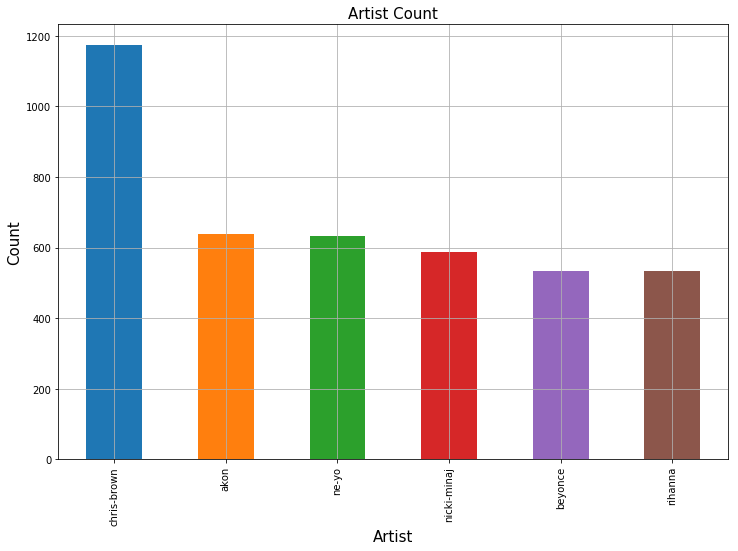

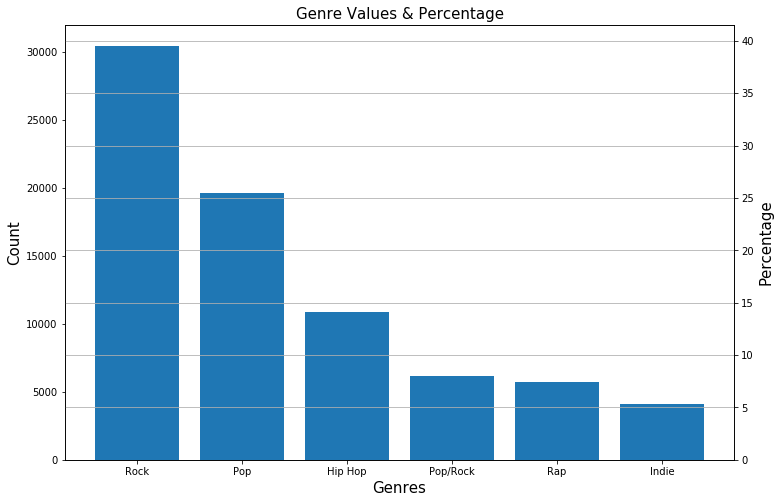

In [22]:
genre_vals = merged_dataset['Genre'].value_counts().nlargest(6)
genre_percentiles = (merged_dataset.Genre.value_counts() / len(merged_dataset)) * 100

plt.figure(figsize=(12,8))
plt.xlabel("Artist", size=15)
plt.ylabel("Count", size=15)
plt.title("Artist Count", size=15)
merged_dataset['ALink'].value_counts().nlargest(6).plot.bar()
plt.grid()
plt.show()

fig, ax1 = plt.subplots(figsize=(12,8))
ax1.set_ylabel("Count", size=15)
ax1.set_xlabel("Genres", size=15)
ax1.bar(genre_vals.keys(), genre_vals.values)

ax2 = ax1.twinx() 
ax2.set_ylabel("Percentage", size=15)
ax2.bar(genre_percentiles.keys(), genre_percentiles.values)
plt.title("Genre Values & Percentage", size=15)

plt.grid()
plt.show()

What's interesting in the plots above, is that we can see that the "Rock" genre is clearly the most common genre in our dataset, making up for 40% of it.

Yet, we can see in the 1st plot, that the most common artist are almost if not all more "Pop" or "Hip Hop" artists

In [23]:
'''
First, we'll drop all the rows which cotain a missing values. 
This is done to ensure no problems will occur during our training time.

Second, we'll stem every word in our tokens columns to make sure its at its proper form
Third, We will join these stemmed tokens back to a string so we can transform it to numerical data to work on
'''

merged_dataset = merged_dataset.dropna()
merged_dataset['tokens'] = [[englishStemmer.stem(x) for x in sent] for sent in merged_dataset['tokens']]
merged_dataset['tokens'] = merged_dataset['tokens'].apply(lambda x: ' '.join(x))

merged_dataset.Genre.value_counts()

Rock        5445
Pop         3144
Hip Hop     1665
Pop/Rock    1322
Rap         1096
Indie        508
Name: Genre, dtype: int64

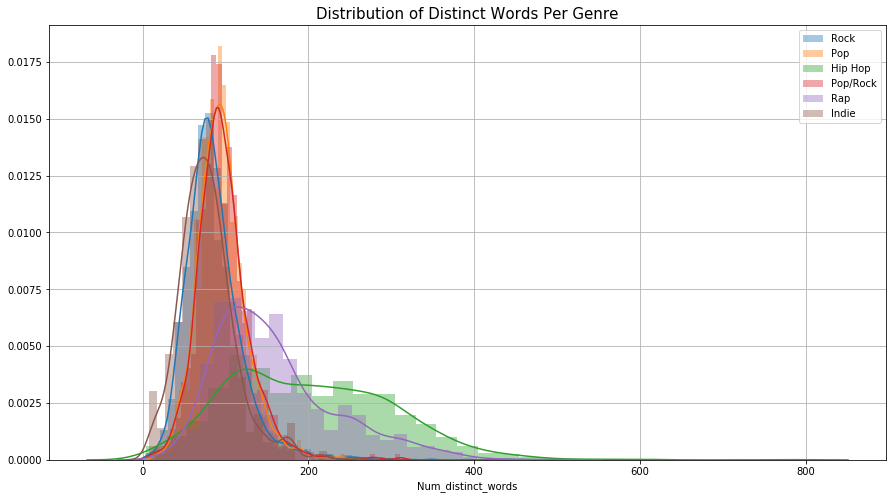

In [24]:
plt.figure(figsize=(15,8))
plt.title("Distribution of Distinct Words Per Genre", size=15)
for gen in merged_dataset.Genre.value_counts().keys():
    sb.distplot(merged_dataset[merged_dataset['Genre'] == gen]['Num_distinct_words'], label=gen)
plt.grid()
plt.legend()
plt.show()

We can see that some genres have a Normal Distribution of the number of distinct words.

i.e. <center> $$ X \sim  \mathcal{N}(\mu,\,\sigma^{2}) $$ </center>

While some genres appear to have a mixture of distributions, these genres include the "Rap" & "Hip Hop" Genres.

In [25]:
N  = 20
N1 = 100
print("Rock Top {} Words:\n{}\n".format(N, Counter(merged_dataset[merged_dataset['Genre'] == 'Rock']['tokens'].str.cat().split()).most_common(N1)[-N:]))
print("Hip-Hop Top {} Words:\n{}\n".format(N, Counter(merged_dataset[merged_dataset['Genre'] == 'Hip Hop']['tokens'].str.cat().split()).most_common(N1)[-N:]))
print("Pop/Rock Top {} Words:\n{}\n".format(N, Counter(merged_dataset[merged_dataset['Genre'] == 'Pop/Rock']['tokens'].str.cat().split()).most_common(N1)[-N:]))
print("Rap Top {} Words:\n{}\n".format(N, Counter(merged_dataset[merged_dataset['Genre'] == 'Rap']['tokens'].str.cat().split()).most_common(N1)[-N:]))
print("Indie Top {} Words:\n{}\n".format(N, Counter(merged_dataset[merged_dataset['Genre'] == 'Indie']['tokens'].str.cat().split()).most_common(N1)[-N:]))
print("Pop Top {} Words:\n{}\n".format(N, Counter(merged_dataset[merged_dataset['Genre'] == 'Pop']['tokens'].str.cat().split()).most_common(N1)[-N:]))

Rock Top 20 Words:
[('lie', 1289), ('walk', 1278), ('alon', 1245), ('face', 1208), ('end', 1189), ('hey', 1176), ('tonight', 1174), ('would', 1171), ('alway', 1170), ('better', 1168), ('die', 1167), ('hear', 1153), ('ever', 1126), ('left', 1121), ('la', 1115), ('head', 1111), ('call', 1104), ('youll', 1079), ('shes', 1073), ('someth', 1071)]

Hip-Hop Top 20 Words:
[('uh', 763), ('turn', 760), ('work', 744), ('start', 729), ('gon', 729), ('mind', 727), ('hand', 722), ('show', 718), ('play', 691), ('well', 689), ('wont', 686), ('ive', 685), ('night', 682), ('alway', 679), ('fuckin', 679), ('name', 678), ('real', 674), ('everi', 659), ('cuz', 658), ('realli', 653)]

Pop/Rock Top 20 Words:
[('id', 330), ('everyth', 328), ('youv', 321), ('walk', 321), ('much', 320), ('hold', 320), ('start', 318), ('mind', 317), ('head', 315), ('run', 313), ('alway', 301), ('us', 299), ('care', 297), ('someth', 296), ('friend', 295), ('light', 295), ('even', 292), ('thought', 289), ('boy', 289), ('stop', 289

In [26]:
merged_dataset['part_of_speech'] = merged_dataset['tokens'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))
merged_dataset['part_of_speech'] = merged_dataset['part_of_speech'].apply(lambda x: np.array(x))

In [27]:
rock_pos, rap_pos, indie_pos, pop_pos,hip_hip_pos, pop_rock_pos = count_genre_pos(merged_dataset, merged_dataset.Genre.value_counts().keys())

In [28]:
pos_list = [rock_pos, rap_pos, indie_pos, pop_pos,hip_hip_pos, pop_rock_pos]
pos_list_names = ['Rock', 'Rap', 'Indie', 'Pop','Hip Hop', 'Pop/Rock']
full_df = pd.DataFrame(columns=[0, 'pos', 'Genre'])

for gen, gen_name in zip(pos_list, pos_list_names):
    gen['pos'] = gen.index
    gen['Genre'] = gen_name 
    gen = gen.sort_values(by=0, ascending=False)
    full_df = full_df.append(gen, ignore_index=True)
    
full_df.columns = ['count', 'pos', 'genre']

In [29]:
pos_df = full_df.groupby(['pos', 'genre','count'] , as_index=False).sum().sort_index(by='count', ascending=False)
pos_df_copy = pos_df[['count', 'pos', 'genre']].copy()

N = 15

top_pos = pos_df_copy.groupby('pos', as_index=False).agg({"count":"sum"}).sort_values(by='count', ascending=False)[:N]['pos']
pos_df_copy = pos_df_copy[pos_df_copy['pos'].isin(top_pos)]

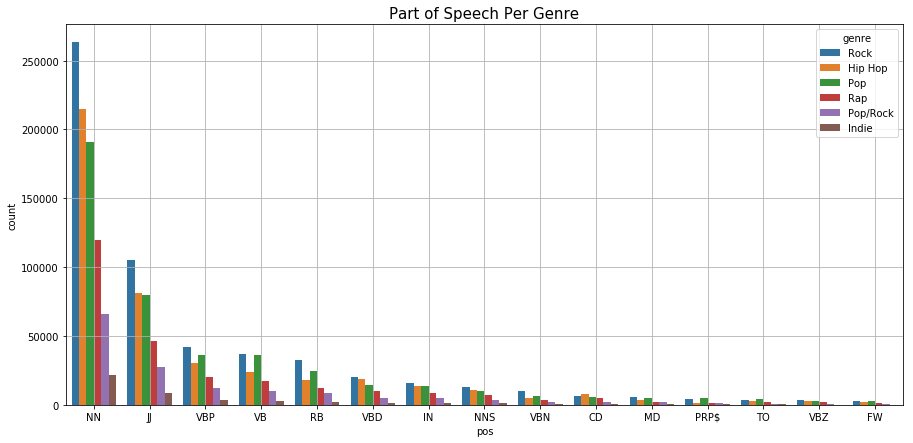

In [30]:
'''
We can see how different genres phrase their lyrics and use different kinds of part of speech tags.
'''
plt.figure(figsize=(15,7))
sb.barplot(data=pos_df_copy, x='pos', y='count', hue='genre')
plt.title("Part of Speech Per Genre", size=15)
plt.grid()
plt.show()

In [31]:
features = list(merged_dataset.select_dtypes('number').columns)
top_genres = list(merged_dataset.Genre.value_counts().nlargest(5).keys())
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', 'v', '+', 'x', '4']

By inspecting the CDF for each genre's feature, we can examine the differences between genres in a more 
thorough way, perhaps contradicting common beliefs.

We can calculate the CDF using the formulation below:

First we need to calculate the Probability Density Function (PDF):
<center> $$PDF  = \frac {Hist}{\sum Hist} $$ </center>

Next, we can calculate the cumulative Distribution Function (CDF):
<center> $$ CDF(k) = \sum_{n=0}^{k}PDF(n) $$ </center>
    

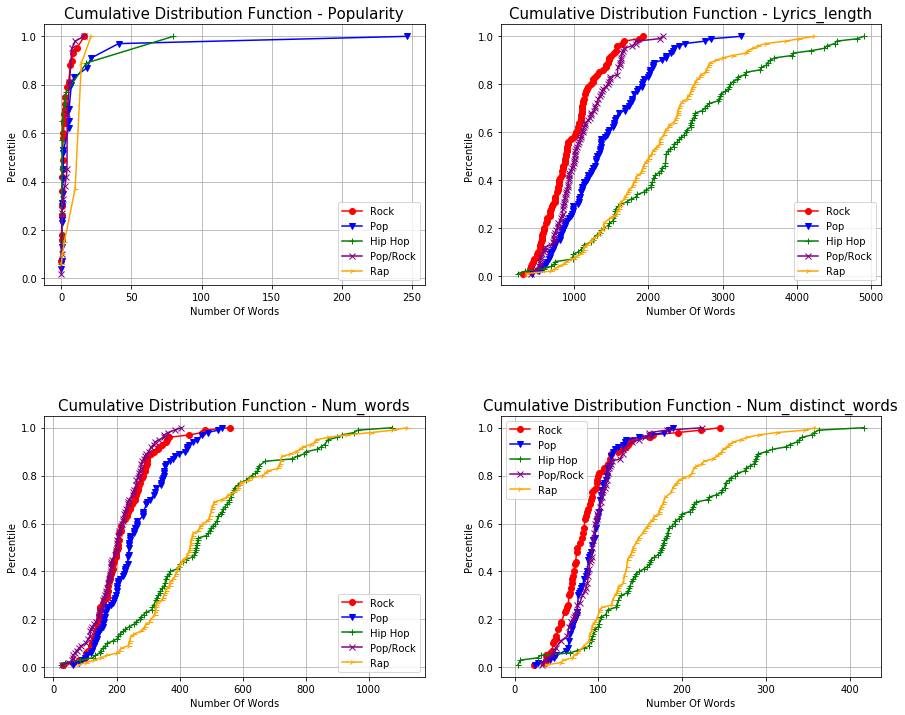

In [32]:
plt.figure(figsize=(15,12))
for ind, feat in enumerate(features):
    if (feat == 'Num_words_title') | (feat == 'year'):
        pass
    else:
        plt.subplot(2, 2, ind + 1)

        for val, col, mark in zip(top_genres, colors, markers):
            CDF, indice_list = generate_CDF(data=merged_dataset[merged_dataset['Genre'] == val].sample(100), feature = feat)
            plt.plot(indice_list.values, CDF,color=col,marker=mark, label=val)

        plt.legend()
        plt.title("Cumulative Distribution Function - " + feat, size=15)
        plt.ylabel("Percentile",size=10)
        plt.xlabel("Number Of Words",size=10)
        plt.grid()
plt.subplots_adjust(hspace=.5)
plt.show()

In [33]:
years = merged_dataset.year.value_counts().sort_index().keys()

In [34]:
merged_dataset['genre_year_probability'] = 0
year_prob_temp_df = pd.DataFrame(columns=merged_dataset.columns)
for year in years:
    first_temp_df = merged_dataset[merged_dataset['year'] == year]
    probas = first_temp_df.Genre.value_counts() / first_temp_df.shape[0]
    probas_dict = dict(zip(probas.keys(), probas.values))

    first_temp_df['genre_year_probability'] = first_temp_df['Genre'].apply(lambda x: probas_dict[x])
    year_prob_temp_df = pd.concat((year_prob_temp_df, first_temp_df))
    
merged_dataset = year_prob_temp_df.sort_index()

Using the next plot, we can observe the change in genre trends along the years.  
We can observe that in the beggining, Rock was actually 100% of the songs,  
but as time progressed more genres appeared and eventually took over,  
dethroning Rock for the first time in 1984 by the "Pop" genre.

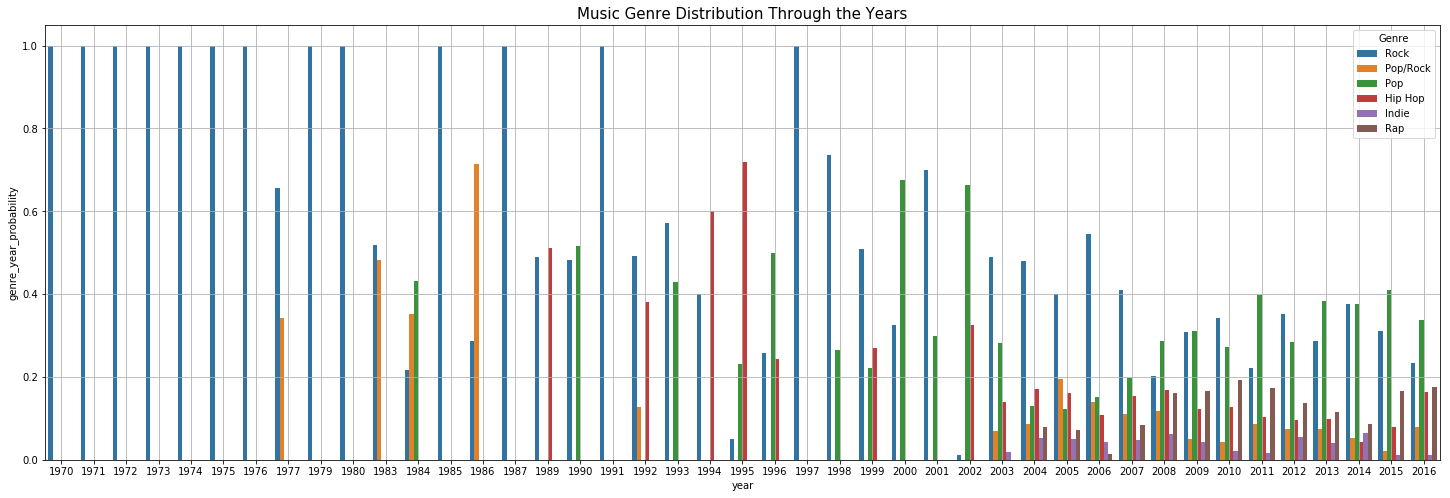

In [35]:
temp = merged_dataset[['year', 'Genre', 'genre_year_probability']].sort_values(by='year', ascending=True)
temp['year'] = temp['year'].astype(int)

plt.figure(figsize=(25,8))
sb.barplot(data= temp, x='year', y='genre_year_probability', hue='Genre')
plt.title("Music Genre Distribution Through the Years", size=15)
plt.grid()
plt.show()

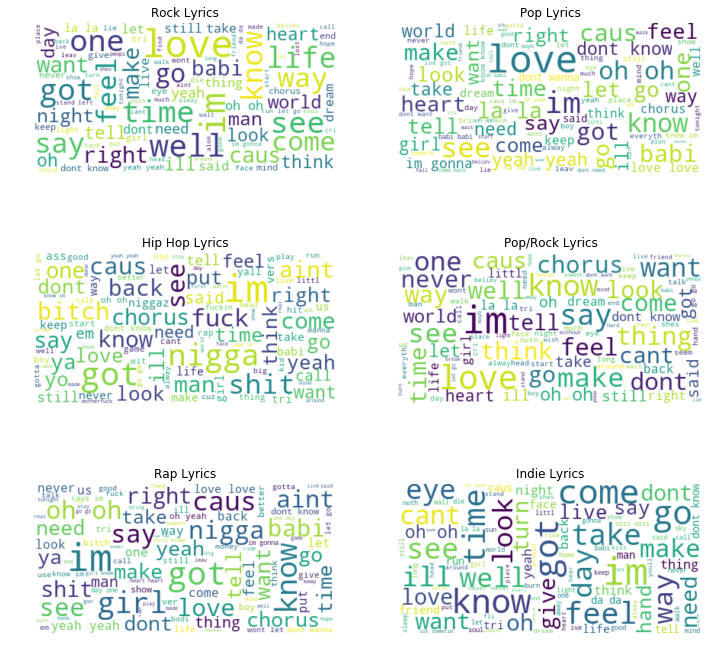

In [36]:
plt.figure(figsize=(12, 12))
for ind, gen in enumerate(merged_dataset.Genre.value_counts().keys()):
    plt.subplot(3, 2, ind + 1)
    words = merged_dataset[merged_dataset['Genre'] == gen]['tokens'].str.cat()
    wordcloud = WordCloud(max_words=100, background_color='white', max_font_size=50).generate(words)

    # Display the generated image:
    plt.title(gen + " Lyrics")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
plt.show()

In [37]:
no_features = 1000
no_topics = 30
no_top_words = 10
ldas = []
for gen in merged_dataset.Genre.value_counts().keys():
    print(gen)
    tf_vectorizer = CountVectorizer(max_df=.95, min_df=2, max_features=no_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(merged_dataset[merged_dataset['Genre'] == gen]['tokens'])
    tf_feature_names = tf_vectorizer.get_feature_names()
    
    lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50, random_state=42)
    lda.fit(tf)
    
    display_topics(lda, tf_feature_names, no_top_words)
    ldas.append(lda.components_)
    print("-"*15)

Rock
Topic 0:
live world eye insid heart broken lie pain life believ
Topic 1:
hell mama nobodi highway wheel daddi spin home roll case
Topic 2:
save white duh wake treat cool guilti tongu ship strength
Topic 3:
like danc boy home rock big play bad old gun
Topic 4:
im gonna caus dont let like got feel know ive
Topic 5:
got time shes good hes right black ive line jack
Topic 6:
know dont feel time like want say way tell thing
Topic 7:
angel beauti heaven whoa star wing light rose street fallen
Topic 8:
ring christma bell magic jump babe step church ow share
Topic 9:
man aint said ah better got talk gotta work come
Topic 10:
long miss lone gone year young anoth carri train home
Topic 11:
ill real someon ive sick doo ha tell drink tire
Topic 12:
dont let away wont run end leav alon fli light
Topic 13:
pretti diddley ho peggi daddi sue knew yes true heart
Topic 14:
day new wonder peopl sea land strang ride mountain sail
Topic 15:
use mani hand power peopl children came boom pay ll
Topic 16:


Topic 0:
check suitcas week havent tape lover shoulder bite quiet choic
Topic 1:
peopl special órale evil watch dumb oh bastard got freak
Topic 2:
ceas sorrow strain ooh great written woman feel bone town
Topic 3:
im yes matine hell follow pleas dark look shop hate
Topic 4:
mountain push tin glori cloud stand shadow tell dirt park
Topic 5:
night shes stay wanna van hes wine got old dont
Topic 6:
dust confess written like air ride life sun nothin pleasur
Topic 7:
fuck truck total dead got want dont laugh blue fuckin
Topic 8:
morn nowher fast happen tell strang hand goin someth teacher
Topic 9:
doo way alon darker alcohol takin pass danc dri wait
Topic 10:
word say noth fascin lip woh curs right ooooh happen
Topic 11:
ohh tambourin black doo card smell blood dress wrong hurrican
Topic 12:
wonder invad pictur state learn drunk compani dollar test wast
Topic 13:
woo ahaiah ass fashion theyll aaaaa ahaaaaah cold heaven comin
Topic 14:
day hey lot like gotta sometim soul need away make
Topic

In [38]:
merged_dataset['Num_distinct_words'] = merged_dataset['Num_distinct_words'].astype(int)
merged_dataset['Num_words_title']    = merged_dataset['Num_words_title'].astype(int)
merged_dataset['Num_words']          = merged_dataset['Num_words'].astype(int)
merged_dataset['Lyrics_length']      = merged_dataset['Lyrics_length'].astype(int)

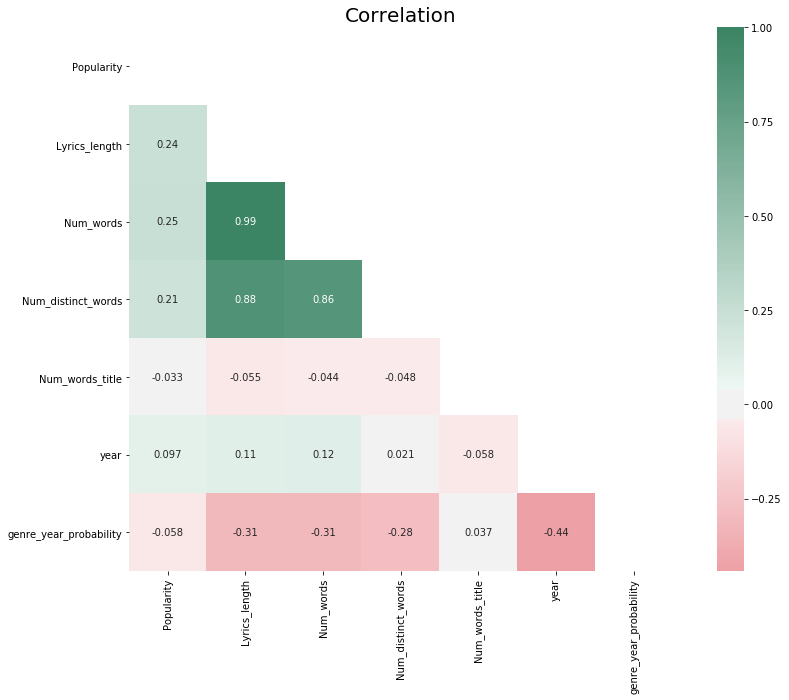

In [39]:
df_corr = merged_dataset._get_numeric_data()

mask = np.zeros_like(df_corr.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sb.diverging_palette(10,150,as_cmap=True)

plt.figure(figsize=(16,10))
sb.heatmap(df_corr.corr(),cmap=cmap,annot=True,mask = mask,square = True,center = 0)
plt.title('Correlation',size=20)
plt.show()



# Genre Prediction
Lets try to build our model!

In [40]:
merged_dataset.select_dtypes('number').describe()

,Popularity,Lyrics_length,Num_words,Num_distinct_words,Num_words_title,year,genre_year_probability
count,13180.000000,13180.000000,13180.000000,13180.000000,13180.000000,13180.000000,13180.000000
mean,6.230144,1339.463581,277.716085,109.878983,2.579590,2007.193854,0.309645
std,18.684542,794.259382,165.188293,64.351655,1.322424,5.989302,0.190282
min,0.000000,18.000000,3.000000,3.000000,1.000000,1970.000000,0.010526
25%,0.300000,810.000000,166.000000,73.000000,2.000000,2006.000000,0.151543
50%,1.200000,1141.000000,236.000000,93.000000,2.000000,2007.000000,0.287054
75%,6.400000,1644.000000,344.000000,123.000000,3.000000,2011.000000,0.409412
max,246.800000,8491.000000,1737.000000,780.000000,19.000000,2016.000000,1.000000


In [41]:
X = merged_dataset['Lyric']
y = merged_dataset['Genre']
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

We can see that we have quite a lot of genres but almost every person know some of these genres are basically "under the same umbrella". i.e. Grunge, Soft Rock, Rock are still considered as "Rock".

Lets try to cluster these genres that way we can group some of these genres into a single class which will help our model to figure out better which song belongs to which genre.

For our model, we will use a Tf-IDF based text transformation.
The formulation is as follows:  

<br> <center> $$ \mbox{tf-idf}_{t,d} = (1 +\log \mbox{tf}_{t,d}) \cdot \log \frac{N}{\mbox{df}_t} $$ </center> </br>

Where:
<br> <center> $$ \mbox {t} \in \mbox{Terms}, \mbox {d} \in \mbox{documents} $$ </center> </br>

In [42]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1,2), stop_words='english')
X = vectorizer.fit_transform(X)
X.shape

(13180, 43993)

In [43]:
genre_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
list(genre_mapping.values())

N = 5
for Product, category_id in sorted(genre_mapping.items()):
    features_chi2 = chi2(X, np.array(y).reshape(-1,1) == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category_id))
    print(". Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print(". Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Hip Hop':
. Most correlated unigrams:
. yo
. fuck
. bitch
. nigga
. shit
. Most correlated bigrams:
. slim shady
. dont fuck
. yo yo
. fat joe
. 50 cent
# 'Indie':
. Most correlated unigrams:
. lard
. molten
. matinee
. ozzy
. i¹m
. Most correlated bigrams:
. nothings right
. falling dont
. did meet
. words right
. shes new
# 'Pop':
. Most correlated unigrams:
. love
. niggas
. fuck
. nigga
. shit
. Most correlated bigrams:
. youre need
. alice petry
. everybody hurts
. real love
. song inside
# 'Pop/Rock':
. Most correlated unigrams:
. invisible
. checkered
. overjoyed
. glances
. ryan
. Most correlated bigrams:
. loved said
. id friends
. repeat chorus
. im angel
. religion religion
# 'Rap':
. Most correlated unigrams:
. chamillionaire
. shawty
. girl
. chris
. akon
. Most correlated bigrams:
. girl wanna
. yeah girl
. baby girl
. girl know
. chris brown
# 'Rock':
. Most correlated unigrams:
. niggas
. gon
. verse
. shit
. nigga
. Most correlated bigrams:
. fat joe
. guitar solo
.

In [44]:
'''
There's no rule as how you should split your data, but it has become a rule of thumb to split 
your data in an 80/20 manner, this means splitting with 80% of the data as the training set
and 20% as the testing set.

We apply the stratify method to make sure a balanced ratio of our target's classes will appear
in our test and training sets.
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

One question which always comes up when we reach the stage of choosing the algorithm is:
How do we choose?
What should we focus on?

Well, there's no way to know which algorithm will work best for your problem, as each problem
is different.

To decide on the right algorithm, usually we test several and compare their results.
For this project, we chose the following 3:
- Logistic Regression -> a simple, yet powerful and time efficient model
  This can be our benchmark model against more advanced algorithms.
  
- Support Vector Machines (SVM) -> a powerful algorithm which is probably the goto for every problem.
  It is robust and can handle most of the problems, unfortunately, it is very sensitive to any changes in
  its hyperparameters, meaning that a single change can either drastically worsen or improve our results.
  
- Random Forest -> also an advanced algorithm which utilizes the "Bagging" trick, this means we basically 
  develop a lot of decision tree based models.

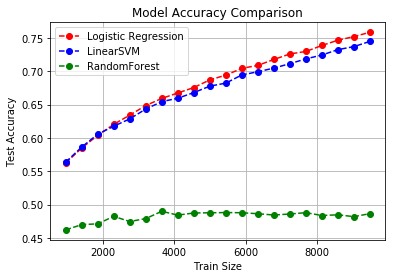

In [45]:
log_reg    = LogisticRegression(random_state=42, n_jobs=-2, C=10, multi_class='ovr')
svc        = LinearSVC(random_state=42, C=10)
forest_clf = RandomForestClassifier(max_depth=10, random_state=42, min_samples_split=10)

clfs       = [log_reg, svc, forest_clf]
colors     = ['red', 'blue', 'green']
clfs_name  = ['Logistic Regression', 'LinearSVM', 'RandomForest']
fit_times  = []

for clf, col, name in zip(clfs, colors, clfs_name):
    t1 = time.time()
    train_sizes, train_scores, test_scores = learning_curve(
        clf, X_train, y_train, cv=10, n_jobs=-1, random_state=42, train_sizes=np.linspace(.1, 1.0, 20))
    fit_times.append(time.time() - t1)
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o--', color=col, label=name)
    

plt.legend()
plt.grid()
plt.title("Model Accuracy Comparison")
plt.xlabel("Train Size")
plt.ylabel("Test Accuracy")
plt.show()

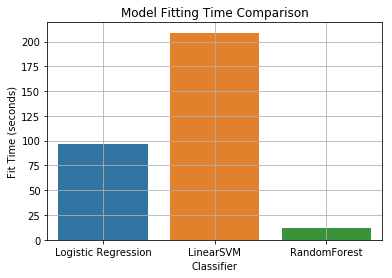

In [46]:
fit_times   = np.array(fit_times).reshape(-1,1)
clfs_name   = np.array(clfs_name).reshape(-1,1)
fit_time_df = pd.DataFrame(np.column_stack((fit_times, clfs_name)), columns=['time', 'classifier'])


sb.barplot(x=fit_time_df['classifier'], y=fit_time_df['time'].astype(float), orient='v')
plt.xlabel("Classifier")
plt.ylabel("Fit Time (seconds)")
plt.title("Model Fitting Time Comparison")
plt.grid()
plt.show()

As we can see, the Logistic Regression maybe one of the simplest models, but in comparison against some of the most sophisticated models, it prevails.  
Proving to be more accurate and time efficient than an SVM & a Random Forest Model

The Logistic Regression Model relies on the "Gradient Descent" optimization function.  
Which is noted by:  

$$\frac {\partial J}{\partial\vec{w}} = \frac {1}{n} \sum_{i=1}^{n} 2\cdot(\vec{w} \vec{x_i} - y_i)\vec{x_i} $$

This is derived from the cost function which is noted by:

$$ J(\vec{w}) = \frac {1}{n} \sum_{i=1}^{n} (\hat{y_i{}} - y_i)^2 $$

Where:
$$ \hat{y_i{}} = \vec{w_i}\cdot{\vec{x_i}} $$

The Logistic Regression Problem:

$$  \hat{y_{}}(\vec{x};\vec{w}) = g(\vec{w}\cdot\vec{x}) $$

where
$\vec{x},\vec{w}\in\mathcal{R}^d$ and $g(\cdot)$ is the sigmoid function:

$$ g(z)=\frac{1}{1+e^{-z}} $$

Using the above equations we can build our Logistic Regression model to fit our data, using the following equation:  

$$  \hat{y_{}}(\vec{x};\vec{w}) = g(\vec{w}\cdot\vec{x}) = g(w_0 + w_1 x)$$

But since our problem doesn't have a single feature, we will develop our model to support a larger dimension problem.  
This will be formulated as the following:

$$  \hat{y_{}}(\vec{x};\vec{w}) = g(\vec{w}\cdot\vec{x}) = g(w_0 + w_1 x_1 + w_2 x_2 + ... + w_d x_d)$$

In [47]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
score = log_reg.score(X_test, y_test)

print("Accuracy Score:",score)
print("K-Fold Cross Validation Accuracy Score :", np.mean(cross_val_score(log_reg, X_train, y_train, cv=10, scoring='accuracy')))
plt.figure(figsize=(10,10))

print("\n\t\t# === CLASSIFICATION REPORT === #")
print("\n",classification_report(y_pred=y_pred, y_true=y_test, target_names=merged_dataset['Genre'].unique()))
print("\n\t\t\t\t# === CONFUSION MATRIX === #")
confusion_matrix_df = pd.DataFrame(data=confusion_matrix(y_pred=y_pred,y_true=y_test))
confusion_matrix_df.columns = "Predicted " +merged_dataset['Genre'].unique()
confusion_matrix_df.index = "Actual " + merged_dataset['Genre'].unique()
confusion_matrix_df

Accuracy Score: 0.7666919575113809
K-Fold Cross Validation Accuracy Score : 0.7589223692948409

		# === CLASSIFICATION REPORT === #

               precision    recall  f1-score   support

        Rock       0.91      0.85      0.88       333
         Pop       0.91      0.21      0.34       102
    Pop/Rock       0.72      0.74      0.73       629
     Hip Hop       0.82      0.39      0.53       264
       Indie       0.92      0.84      0.88       219
         Rap       0.72      0.89      0.80      1089

   micro avg       0.77      0.77      0.77      2636
   macro avg       0.83      0.65      0.69      2636
weighted avg       0.78      0.77      0.75      2636


				# === CONFUSION MATRIX === #


,Predicted Rock,Predicted Pop,Predicted Pop/Rock,Predicted Hip Hop,Predicted Indie,Predicted Rap
Actual Rock,282,0,16,0,13,22
Actual Pop,1,21,9,1,0,70
Actual Pop/Rock,7,0,465,9,3,145
Actual Hip Hop,0,0,39,102,0,123
Actual Indie,14,0,12,1,185,7
Actual Rap,6,2,103,11,1,966


<Figure size 720x720 with 0 Axes>

<br> <center> $$\large Recall    = \frac{\Large True Positive}{\Large True Positive + False Negative}$$  </center> </br>

<br> <center> $$\large Precision = \frac{\Large True Positive}{\Large True Positive + False Positive}$$  </center> </br>

<br> <center> $$\large F1        = \frac{\Large 2 \cdot Precision\cdot Recall}{\Large Precision + Recall}$$ </center> </br>

Inspecting our results we can see that for some genres, our model is very precise!  
Achieving over 90% precision score! yet we see that he also has some bad recall scores for several genres, mixing them with other genres.

For example:   
We can see that our model predicted the "Pop" genre with over 90% precision, but with a mere 20% recall.  
This is because it confused mainly with the Rap genre, this might be because of the common corpus these 2 genres share, or rather because we have a low amount of data samples from the "Pop" genre.

#### CONCLUSION:
Our model has a score of 77% accuracy with 6 different classes, some say it might not be that great.
But for this project, we'll conclude that there's definetly a connection between a song's genre and its lyrics.

In [48]:
'''
Using our model's coefficients, we can reverse transform these features back into their coresponding tokens.
This way we can visualize what were the most impactful tokens which helped our model destinguish between
each genre of music.

This way we can asses if there's truely a connection between the song's genre to a certain genre, 
or perhaps explain any mistakes which occured in our classification.
'''
top_N = 20

cols                 = np.arange(X.shape[1])
xtrain               = pd.DataFrame(data=X_test.todense(), columns=cols)
coef                 = list(sorted(zip(xtrain.columns,abs(log_reg.coef_[0])),key=lambda x: x[1]))
coef_table           = pd.DataFrame(np.array(coef).reshape(-1,2),columns=['Attributes','Coefficient'])
reverse_word_map     = dict(map(reversed, vectorizer.vocabulary_.items()))
coef_table['Tokens'] = coef_table['Attributes'].apply(lambda x: reverse_word_map[x])

print('Coefficient for top {} features:\n'.format(top_N))
coef_table.iloc[-1:-top_N:-1,:]

Coefficient for top 20 features:



,Attributes,Coefficient,Tokens
43992,39842.0,11.217068,verse
43991,32957.0,8.241221,shit
43990,2820.0,7.117575,bitch
43989,9782.0,6.249551,eminem
43988,6368.0,6.076309,common
43987,25433.0,6.019882,mike
43986,5000.0,5.644125,chamillionaire
43985,43341.0,5.642875,yo
43984,41941.0,5.478265,wit
43983,2141.0,5.432533,beastie


# Year Prediction

In [49]:
vectorizer = TfidfVectorizer(stop_words='english', analyzer='word', lowercase=True, ngram_range=(1,2))
X = vectorizer.fit_transform(merged_dataset['tokens'])

In [50]:
merged_dataset['year'] = merged_dataset['year'].astype(int)
merged_dataset['era'] = merged_dataset['year'].apply(lambda x:str(x - x % 10) + ' - ' + str(x + (10 - (x % 10))) )
merged_dataset[['Lyric', 'year', 'era']].head()

,Lyric,year,era
0,i could feel at the time there was no way of k...,2006,2000 - 2010
1,take me now baby here as i am hold me close an...,2006,2000 - 2010
2,these are these are days youll remember never ...,2006,2000 - 2010
3,"a lie to say ""o my mountain has coal veins and...",2006,2000 - 2010
4,trudging slowly over wet sand back to the benc...,2006,2000 - 2010


In [51]:
y1 = LabelEncoder().fit_transform(merged_dataset['year'])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42, stratify=y1)

In [53]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
score = log_reg.score(X_test, y_test)

print("Accuracy Score:",score)
print("K-Fold Cross Validation Accuracy Score :", np.mean(cross_val_score(log_reg, X_train, y_train, cv=10, scoring='accuracy')))

print("\n\t# === CLASSIFICATION REPORT === #")
print("\n",classification_report(y_pred=y_pred, y_true=y_test, target_names=merged_dataset['year'].astype(str).unique()))#, target_names=merged_dataset['year'].unique()))
# print("\n\t# === CONFUSION MATRIX === #")
confusion_matrix_df = pd.DataFrame(data=confusion_matrix(y_pred=y_pred,y_true=y_test))
confusion_matrix_df.columns = "Predicted " +merged_dataset['year'].astype(str).unique()
confusion_matrix_df.index = "Actual " + merged_dataset['year'].astype(str).unique()

Accuracy Score: 0.5834597875569044
K-Fold Cross Validation Accuracy Score : 0.5689533143382985

	# === CLASSIFICATION REPORT === #

               precision    recall  f1-score   support

        2006       0.00      0.00      0.00         4
        2007       1.00      0.50      0.67         2
        2004       1.00      0.50      0.67         2
        2012       0.00      0.00      0.00         7
        2010       1.00      0.25      0.40         4
        2008       0.00      0.00      0.00         2
        2014       0.00      0.00      0.00         1
        2011       1.00      0.14      0.25         7
        2009       0.00      0.00      0.00         2
        2005       0.00      0.00      0.00         1
        1995       1.00      0.20      0.33         5
        1992       1.00      0.29      0.44         7
        2015       0.00      0.00      0.00         2
        2013       0.00      0.00      0.00         3
        2016       0.00      0.00      0.00         2
  

In [54]:
top_N = 20

cols                 = np.arange(X.shape[1])
xtrain               = pd.DataFrame(data=X_test.todense(), columns=cols)
coef                 = list(sorted(zip(xtrain.columns,abs(log_reg.coef_[0])),key=lambda x: x[1]))
coef_table           = pd.DataFrame(np.array(coef).reshape(-1,2),columns=['Attributes','Coefficient'])
reverse_word_map     = dict(map(reversed, vectorizer.vocabulary_.items()))
coef_table['Tokens'] = coef_table['Attributes'].apply(lambda x: reverse_word_map[x])

print('Coefficient for top {} features:\n'.format(top_N))
coef_table.iloc[-1:-top_N:-1,:]

Coefficient for top 20 features:



,Attributes,Coefficient,Tokens
544403,64984.0,4.299186,california girl
544402,185319.0,4.173167,god know
544401,332616.0,4.016845,oh oh
544400,229703.0,3.933831,id god
544399,266615.0,3.902779,let home
544398,525600.0,3.548913,wish california
544397,30217.0,3.543724,barbara ann
544396,30216.0,3.382960,barbara
544395,255850.0,3.095166,know id
544394,15198.0,3.075840,ann


In [56]:
y2 = LabelEncoder().fit_transform(merged_dataset['era'])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2, random_state=42, stratify=y2)

In [58]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
score = log_reg.score(X_test, y_test)

print("Accuracy Score:",score)
print("K-Fold Cross Validation Accuracy Score :", np.mean(cross_val_score(log_reg, X_train, y_train, cv=10, scoring='accuracy')))

print("\n\t# === CLASSIFICATION REPORT === #")
print("\n",classification_report(y_pred=y_pred, y_true=y_test, target_names=merged_dataset['era'].astype(str).unique()))
print("\n\t# === CONFUSION MATRIX === #")
confusion_matrix_df = pd.DataFrame(data=confusion_matrix(y_pred=y_pred,y_true=y_test))
confusion_matrix_df.columns = "Predicted " +merged_dataset['era'].astype(str).unique()
confusion_matrix_df.index = "Actual " + merged_dataset['era'].astype(str).unique()
confusion_matrix_df

Accuracy Score: 0.7993171471927162
K-Fold Cross Validation Accuracy Score : 0.7837638140572529

	# === CLASSIFICATION REPORT === #

               precision    recall  f1-score   support

 2000 - 2010       0.88      0.23      0.36        31
 2010 - 2020       1.00      0.37      0.54        30
 1990 - 2000       0.90      0.52      0.66       103
 1980 - 1990       0.79      0.95      0.86      1671
 1970 - 1980       0.83      0.56      0.67       801

   micro avg       0.80      0.80      0.80      2636
   macro avg       0.88      0.53      0.62      2636
weighted avg       0.81      0.80      0.78      2636


	# === CONFUSION MATRIX === #


,Predicted 2000 - 2010,Predicted 2010 - 2020,Predicted 1990 - 2000,Predicted 1980 - 1990,Predicted 1970 - 1980
Actual 2000 - 2010,7,0,1,21,2
Actual 2010 - 2020,0,11,0,16,3
Actual 1990 - 2000,0,0,54,46,3
Actual 1980 - 1990,1,0,2,1586,82
Actual 1970 - 1980,0,0,3,349,449


<Figure size 720x720 with 0 Axes>

# Popularity Prediction

In [72]:
y_popularity = merged_dataset['Popularity'].copy()

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y_popularity, test_size=0.2, random_state=42)

In [144]:
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(X_train, y_train)
print("K-Fold Cross Validation RMSE Score :", -1*np.mean(cross_val_score(lin_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')))

K-Fold Cross Validation RMSE Score : 284.4044557172768


It appears our model is greatly inaccurate, producing a mean squared error of 284 (the lower the better).
This is a terrible score considering the fact that our values range is between 0 and 8~ (with 248 being a noisy sample).